In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# A simple Recommendation System using the weighted-average rating of each developer

In [2]:
import pandas as pd
import numpy as np
from numpy import mean

import seaborn as sns
import matplotlib.pyplot as plt

# anonymize data
import unicodecsv as csv
from collections import defaultdict
from faker import Faker

from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

### read in data

In [3]:
df = pd.read_csv("data/peopleperhour_clean_data.csv").drop(["Unnamed: 0"], axis=1)

<IPython.core.display.Javascript object>

In [4]:
# drop duplicates by duplicate names
df = df.drop_duplicates(subset="name")

<IPython.core.display.Javascript object>

## Anonymize data

### soln1:create fake names

In [5]:
fake = Faker()


def fake_name(row):
    return fake.name()


df["name"] = df.apply(fake_name, axis=1)

<IPython.core.display.Javascript object>

### soln2:map names to numbers

In [6]:
# track mapping of names to numbers
my_dict = dict(zip(list(df["name"].unique()), range(len(list(df["name"].unique())))))

<IPython.core.display.Javascript object>

In [7]:
df_encoded = (
    df.reset_index().drop(["name"], axis=1).rename({"index": "names_encoded"}, axis=1)
)

<IPython.core.display.Javascript object>

### convert ratings to USD

In [8]:
# convert rate row to rate_USD
for idx, row in df.rate.items():
    if "£" in row:
        row = row.split("£")[1]
        df.at[idx, "rate"] = round(int(row) * 1.37, 2)
    if "€" in row:
        row = row.split("€")[1]
        df.at[idx, "rate"] = round(int(row) * 1.16, 2)
    if "$" in row:
        row = row.split("$")[1]
        df.at[idx, "rate"] = row

<IPython.core.display.Javascript object>

# Simple Recommendation Machine based on rating only
## Decide on the metric or score to rate developers on.
#### rating
## Calculate the score for every developer.
#### rating/num_work_samples
## Sort the developers based on the score and output the top results.

<AxesSubplot:>

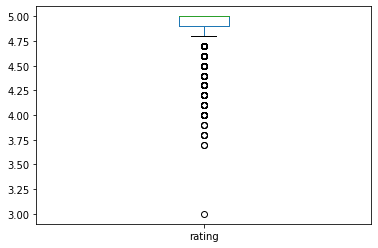

<IPython.core.display.Javascript object>

In [9]:
df.rating.plot(kind="box")

<AxesSubplot:>

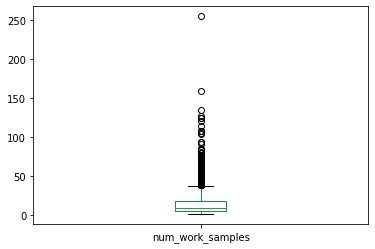

<IPython.core.display.Javascript object>

In [10]:
df.num_work_samples.plot(kind="box")

In [11]:
X = weight_average["num_work_samples"]
Y = weight_average["rating"]
plt.plot(X, Y, "o")
# line of best fit
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X) / len(X)
    ybar = sum(Y) / len(Y)
    n = len(X)  # or len(Y)

    numer = sum([xi * yi for xi, yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi ** 2 for xi in X]) - n * xbar ** 2

    b = numer / denum
    a = ybar - b * xbar

    print("best fit line:\ny = {:.2f} + {:.2f}x".format(a, b))

    return a, b


# solution
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit)

NameError: name 'weight_average' is not defined

<IPython.core.display.Javascript object>

Clearly, the dataset contains many developers with few work samples and high ratings. In order to generate a more robust comparison of developers, let's incorporate a developer's number of work samples to their rating score to yield a weighted average rating.

# Calculate weighted average

In [ ]:
# percentage of developers with only one work sample
len(df[df["num_work_samples"] < 5]) / len(df)

In [ ]:
### movies_cleaned_df[‘weighted_average’]=((R*v)+ (C*m))/(v+m)
v = df["num_work_samples"]
R = df["rating"]
C = mean(df["rating"])
m = df["num_work_samples"].quantile(
    0.25
)  # must have more votes than at least 25% of developers in the dataset

In [ ]:
m  # developers with less than 5 work samples being excluded

In [ ]:
df["weighted_average"] = ((R * v) + (C * m)) / (v + m)

In [ ]:
weight_average = df.sort_values(by="weighted_average", ascending=False).dropna()

In [ ]:
plt.figure(figsize=(16, 10), dpi=80)
sns.kdeplot(
    weight_average["weighted_average"],
    shade=True,
    color="purple",
    legend=False,
    alpha=0.8,
)
sns.kdeplot(
    df["rating"],
    shade=True,
    color="black",
    legend=False,
)

# Decoration
plt.title("Density Plot (Distribution) of Developer Weighted Average", fontsize=18)
plt.show()

We can see that by accounting for num_work_samples, the new (purple) distribution has been moved slightly left, i.e. is slightly more centered.

### Recommendation based on scaled weighted average and num_work_samples (proxy for popularity) score (priority-50% for both):

In [ ]:
# Create an object and pass the two attributes ‘weighted_average’ and ‘num_work_samples’ that need to be normalised.
# Convert to a dataframe and display the scaled-down data.
scaling=MinMaxScaler()
weight_average_scaled=scaling.fit_transform(weight_average[['weighted_average', 'num_work_samples']])
normalized_df=pd.DataFrame(weight_average_scaled,columns=['weighted_average', 'num_work_samples'])


In [ ]:
normalized_df["name"] = weight_average["name"]  # assign names to normalized_df

### Based just on weighted average and popularity (i.e. number of projects done), a simple recommender would return recommendations in the following order...

In [ ]:
normalized_df

# Sources
https://medium.com/@developeraritro/building-a-recommendation-system-using-weighted-hybrid-technique-75598b6be8ed